### Projeto - Crimes em Boston

- __Nome:__ Gustavo Rezende Melo
- __Disciplina:__ Mineração de Dados
- __Projeto:__ Crimes em Boston

## Fase 2

### Importação das bibliotecas principais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### Importação da base de dados

In [2]:
crimes = pd.read_csv('C:\\Users\\Gustavo\\OneDrive\\MBA\\MBA Data Science\\Projeto B2\\crimes\\crimes2.csv', sep=';', parse_dates=['DATA_OCORRENCIA'])

### Pré-processamento

Primeiramente, vamos verificar as estatísticas descritivas e contagem de valores da base de dados.

In [10]:
crimes.head()

,NUMERO_INCIDENTE,CODIGO_CRIME,CODIGO_GRUPO_CRIME,DESCRICAO_CRIME,DISTRITO,AREA_REPORTADA,TEVE_TIRO,DATA_OCORRENCIA,ANO,MES,DIA_DA_SEMANA,HORA,ALTO_RISCO,DIA_MES
0,I182070933,724,Auto Theft,AUTO THEFT,B2,330,0,2018-03-09 21:25:00,2018,3,Monday,21,0.0,9
1,I182070932,3301,Verbal Disputes,VERBAL DISPUTE,B2,584,0,2018-03-09 20:39:00,2018,3,Monday,20,0.0,9
2,I182070917,2647,Other,THREATS TO DO BODILY HARM,B2,901,0,2018-03-09 19:52:00,2018,3,Monday,19,0.0,9
3,I182070915,614,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,B2,181,0,2018-02-09 18:00:00,2018,2,Sunday,18,0.0,9
4,I182070908,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,B2,911,0,2018-03-09 18:38:00,2018,3,Monday,18,0.0,9


In [4]:
crimes.describe()

,CODIGO_CRIME,TEVE_TIRO,ANO,MES,HORA,ALTO_RISCO
count,9823.000000,9823.000000,9823.000000,9823.000000,9823.000000,9822.000000
mean,2404.181615,0.006719,2017.994299,4.709559,13.188232,0.094889
std,1158.172349,0.081697,0.080520,2.303406,6.336930,0.293077
min,111.000000,0.000000,2015.000000,1.000000,0.000000,0.000000
25%,1304.000000,0.000000,2018.000000,3.000000,9.000000,0.000000
50%,3006.000000,0.000000,2018.000000,5.000000,14.000000,0.000000
75%,3301.000000,0.000000,2018.000000,7.000000,18.000000,0.000000
max,3831.000000,1.000000,2018.000000,12.000000,23.000000,1.000000


In [5]:
crimes.count()

NUMERO_INCIDENTE      9823
CODIGO_CRIME          9823
CODIGO_GRUPO_CRIME    9823
DESCRICAO_CRIME       9823
DISTRITO              9823
AREA_REPORTADA        9823
TEVE_TIRO             9823
DATA_OCORRENCIA       9823
ANO                   9823
MES                   9823
DIA_DA_SEMANA         9823
HORA                  9823
ALTO_RISCO            9822
dtype: int64

Podemos observar que há um valor faltante na coluna de risco. Vamos eliminar essa linha.

In [6]:
crimes=crimes.dropna()

In [7]:
crimes.count()

NUMERO_INCIDENTE      9822
CODIGO_CRIME          9822
CODIGO_GRUPO_CRIME    9822
DESCRICAO_CRIME       9822
DISTRITO              9822
AREA_REPORTADA        9822
TEVE_TIRO             9822
DATA_OCORRENCIA       9822
ANO                   9822
MES                   9822
DIA_DA_SEMANA         9822
HORA                  9822
ALTO_RISCO            9822
dtype: int64

Vamos agora acrescentar as informações do dia do mês que a ocorrência aconteceu e corrigir o número do mês.

In [8]:
crimes['DIA_MES']=pd.DatetimeIndex(crimes['DATA_OCORRENCIA']).day
crimes['MES']=pd.DatetimeIndex(crimes['DATA_OCORRENCIA']).month

Como é necessário que todas as colunas que serão utilizadas tenham valores numéricos, vamos verificar isso e alterar se necessário.

In [9]:
crimes.dtypes

NUMERO_INCIDENTE              object
CODIGO_CRIME                   int64
CODIGO_GRUPO_CRIME            object
DESCRICAO_CRIME               object
DISTRITO                      object
AREA_REPORTADA                object
TEVE_TIRO                      int64
DATA_OCORRENCIA       datetime64[ns]
ANO                            int64
MES                            int64
DIA_DA_SEMANA                 object
HORA                           int64
ALTO_RISCO                   float64
DIA_MES                        int64
dtype: object

Como utilizaremos o dado de AREA_REPORTADA e este não é númerico, vamos converter.

In [11]:
crimes['AREA_REPORTADA']=pd.to_numeric(crimes['AREA_REPORTADA'],errors='coerce')

Vamos agora criar uma nova dataframe "crimes2" contendo apenas as colunas que serão utilizadas na geração do modelo.

In [12]:
crimes2=crimes[['CODIGO_CRIME', 'AREA_REPORTADA', 'TEVE_TIRO', 'ANO', 'MES','DIA_DA_SEMANA','DIA_MES', 'HORA','ALTO_RISCO']].copy()

Vamos verificar se a conversão de AREA_REPORTADA trouxe algum problema para os valores da coluna.

In [13]:
crimes2.count()

CODIGO_CRIME      9822
AREA_REPORTADA    9120
TEVE_TIRO         9822
ANO               9822
MES               9822
DIA_DA_SEMANA     9822
DIA_MES           9822
HORA              9822
ALTO_RISCO        9822
dtype: int64

Havia valores " " que foram convertidos para "NaN". Vamos corrigir isso.

In [14]:
crimes2.dropna(inplace=True)

In [15]:
crimes2.replace(regex={'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}, inplace=True)

### Manipulação da base

Agora vamos dividir o dataframe na matriz de características "X"(que será utilizada para prever as respostas) e o vetor resposta "y". O vetor resposta é a coluna "ALTO_RISCO" que queremos prever.

In [16]:
X=crimes2[['CODIGO_CRIME', 'AREA_REPORTADA', 'TEVE_TIRO', 'ANO', 'MES','DIA_DA_SEMANA','DIA_MES', 'HORA',]].copy()

In [17]:
y=crimes2['ALTO_RISCO']

Vamos dividir as características e as respostas em duas partes: uma que será utilizada para treino e outra que será usada para testar o modelo.

In [18]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

### Aplicação da técnica
- __Nome da técnica:__ Árvore de decisão
<br>__Referências complementares__: https://scikit-learn.org/stable/user_guide.html

Para aplicar a técnica, cria-se a instância do classificador, quantos nós a árvore terá e define-se o critério que será utilizado: entropia.

In [19]:
arvorecrimes = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

Em seguida, utilizamos os dados de treinamento para ajustar o modelo.

In [20]:
arvorecrimes.fit(X_trainset,y_trainset)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Podemos agora utilizar os dados de teste das características para fazer a previsão dos valores de resposta. Esses serão comparados com os valores de teste de resposta para podermos avaliar o modelo.

In [21]:
arvorepred = arvorecrimes.predict(X_testset)

Podemos observar os primeiros 5 dados do vetor previsto e comparar com os dados de teste, para ver se estão muito discrepantes.

In [22]:
print (arvorepred [0:5])
print (y_testset [0:5])

[0. 0. 0. 0. 0.]
7647    0.0
5007    0.0
8872    0.0
1141    0.0
2237    1.0
Name: ALTO_RISCO, dtype: float64


Num primeiro momento, tudo certo. Vamos verificar algumas métricas para avaliar o desempenho.

### Saída de resultados

In [23]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, arvorepred))

DecisionTrees's Accuracy:  0.972953216374269


In [24]:
print("DecisionTrees's Precision: ", metrics.precision_score(y_testset, arvorepred))

DecisionTrees's Precision:  1.0


Vamos gerar a árvore para observar quais características o algoritmo utilizou para criar o modelo.

In [25]:
from sklearn import tree

[Text(567.9642857142857, 733.86, 'X[0] <= 471.5\nentropy = 0.419\nsamples = 6384\nvalue = [5842, 542]'),
 Text(239.14285714285714, 570.78, 'X[0] <= 206.0\nentropy = 0.149\nsamples = 282\nvalue = [6, 276]'),
 Text(119.57142857142857, 407.70000000000005, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(358.7142857142857, 407.70000000000005, 'entropy = 0.0\nsamples = 276\nvalue = [0, 276]'),
 Text(896.7857142857142, 570.78, 'X[0] <= 2957.5\nentropy = 0.259\nsamples = 6102\nvalue = [5836, 266]'),
 Text(597.8571428571429, 407.70000000000005, 'X[0] <= 2902.5\nentropy = 0.438\nsamples = 2898\nvalue = [2636, 262]'),
 Text(478.2857142857143, 244.62, 'X[0] <= 768.0\nentropy = 0.278\nsamples = 2769\nvalue = [2636, 133]'),
 Text(358.7142857142857, 81.54000000000008, 'entropy = 0.0\nsamples = 814\nvalue = [814, 0]'),
 Text(597.8571428571429, 81.54000000000008, 'entropy = 0.359\nsamples = 1955\nvalue = [1822, 133]'),
 Text(717.4285714285714, 244.62, 'entropy = 0.0\nsamples = 129\nvalue = [0, 129

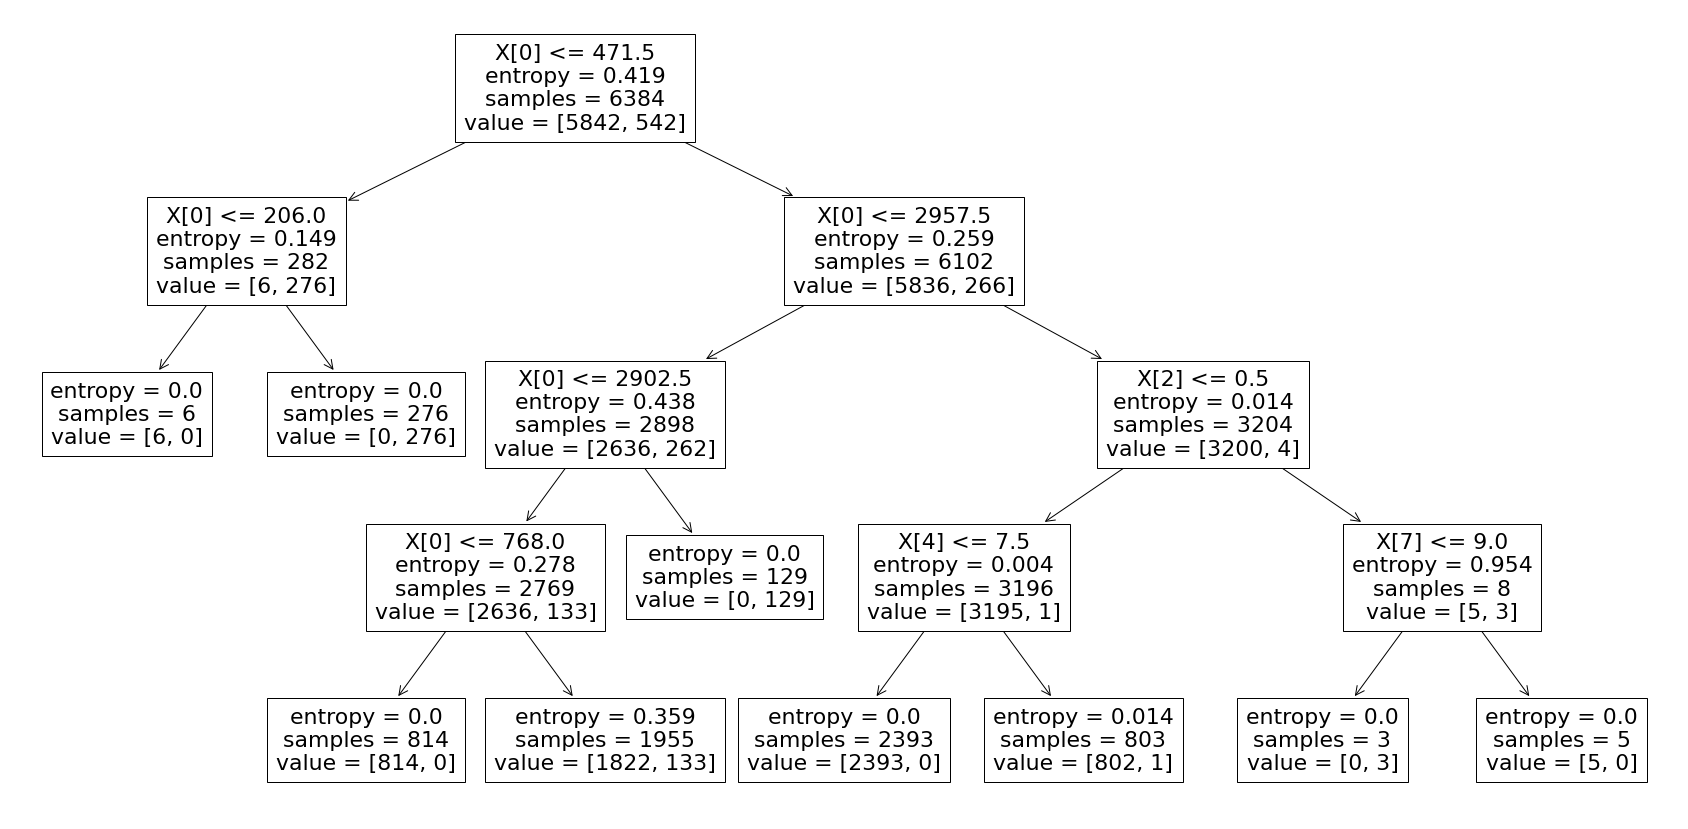

In [26]:
plt.figure(figsize=(30,15))
tree.plot_tree(arvorecrimes)

As colunas que foram utilizadas foram as colunas 0 (CODIGO_CRIME), 2(TEVE_TIRO), 4(MES) e 7(HORA). Vamos criar a matriz de confusão para ver a comparação entre os resultados previstos e os reais.

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [28]:
confusion_matrix(y_testset, arvorepred)

array([[2460,    0],
       [  74,  202]], dtype=int64)

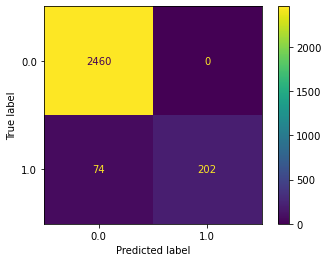

In [41]:
plot_confusion_matrix(arvorecrimes, X_testset, y_testset, values_format = '.0f')

Podemos observar que tivemos: 
- 2460 crimes de classificação "0" foram previstos como "0" corretamente.
- Tivemos 202 casos de classificação "1" previstos corretamente na classificação "1".
- Tivemos 74 ocorrências classificadas como "1" e foram previstos como "0", sendo os falsos negativos.
- Não tivemos casos de classificação "0" previstos como classificação "1", que seriam os falsos positivos.

Refazendo a árvores removendo as colunas de CODIGO_CRIME e TEVE_TIRO temos a árvore abaixo.

In [30]:
X2=crimes2[['AREA_REPORTADA', 'ANO', 'MES','DIA_DA_SEMANA','DIA_MES', 'HORA',]].copy()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=3)

In [32]:
arvorecrimes2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [33]:
arvorecrimes2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [34]:
arvorepred2 = arvorecrimes2.predict(X_test)

In [35]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, arvorepred2))
print("DecisionTrees's Precision: ", metrics.precision_score(y_test, arvorepred2))

DecisionTrees's Accuracy:  0.8991228070175439
DecisionTrees's Precision:  0.0


C:\Users\Gustavo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(911.7321428571429, 733.86, 'X[5] <= 5.5\nentropy = 0.419\nsamples = 6384\nvalue = [5842, 542]'),
 Text(478.2857142857143, 570.78, 'X[0] <= 280.5\nentropy = 0.617\nsamples = 824\nvalue = [698, 126]'),
 Text(239.14285714285714, 407.70000000000005, 'X[0] <= 264.5\nentropy = 0.769\nsamples = 240\nvalue = [186, 54]'),
 Text(119.57142857142857, 244.62, 'X[0] <= 210.5\nentropy = 0.7\nsamples = 169\nvalue = [137, 32]'),
 Text(59.785714285714285, 81.54000000000008, 'entropy = 0.811\nsamples = 84\nvalue = [63, 21]'),
 Text(179.35714285714286, 81.54000000000008, 'entropy = 0.556\nsamples = 85\nvalue = [74, 11]'),
 Text(358.7142857142857, 244.62, 'X[2] <= 4.5\nentropy = 0.893\nsamples = 71\nvalue = [49, 22]'),
 Text(298.92857142857144, 81.54000000000008, 'entropy = 0.485\nsamples = 19\nvalue = [17, 2]'),
 Text(418.5, 81.54000000000008, 'entropy = 0.961\nsamples = 52\nvalue = [32, 20]'),
 Text(717.4285714285714, 407.70000000000005, 'X[0] <= 293.5\nentropy = 0.539\nsamples = 584\nvalue = [512,

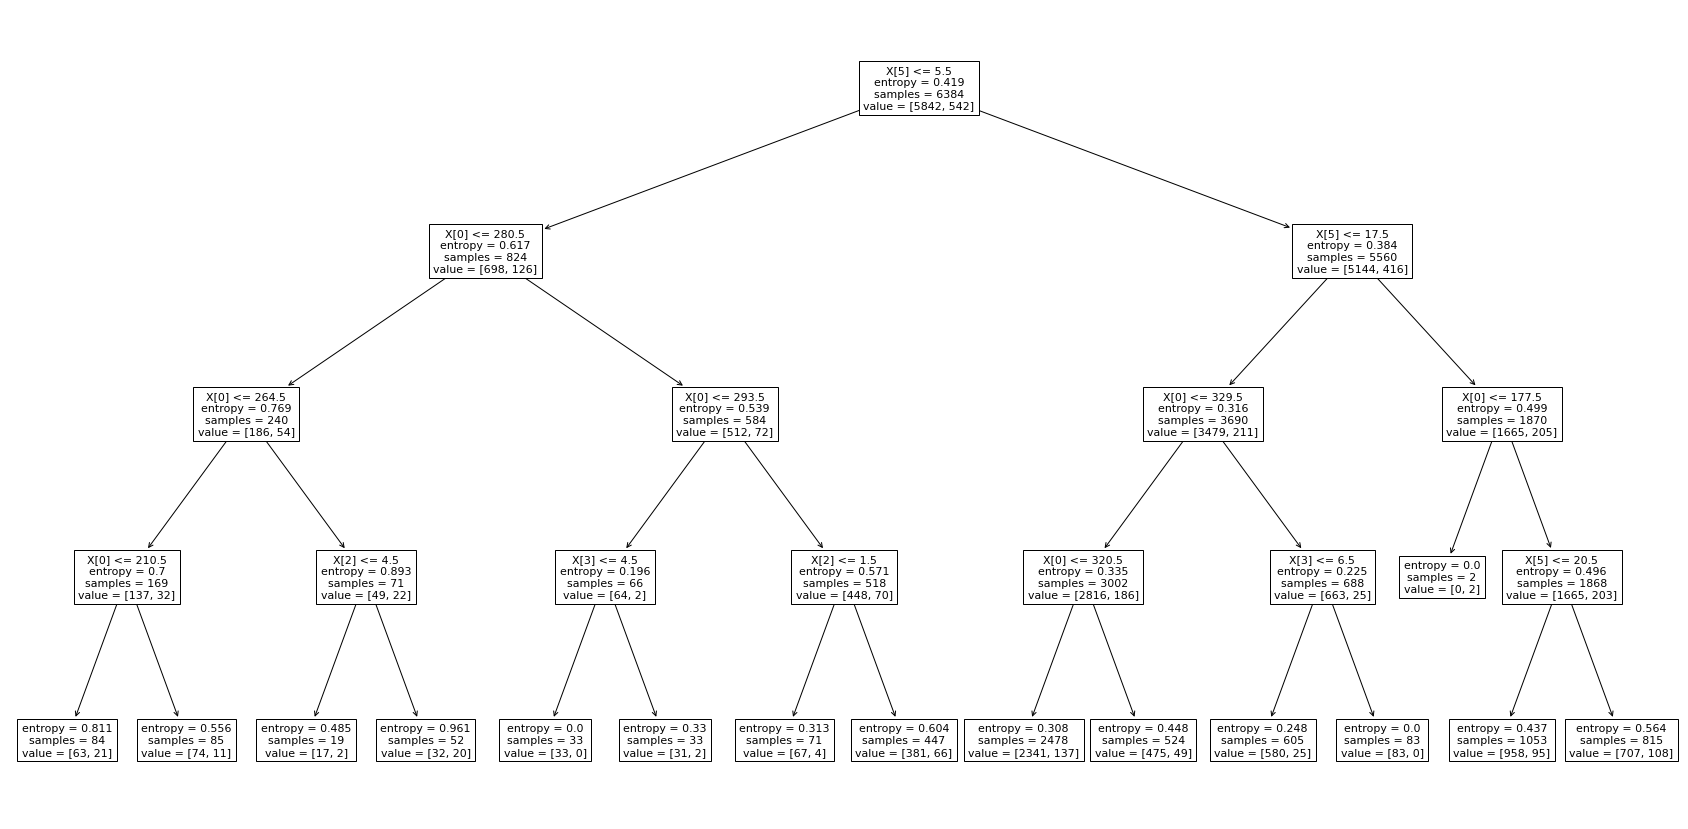

In [36]:
plt.figure(figsize=(30,15))
tree.plot_tree(arvorecrimes2)

As colunas que foram utilizadas foram as colunas 5(HORA), 0(AREA), 2(MES) e 3(DIA_DA_SEMANA). Vamos criar a matriz de confusão para ver a comparação entre os resultados previstos e os reais.

In [37]:
confusion_matrix(y_test, arvorepred2)

array([[2460,    0],
       [ 276,    0]], dtype=int64)

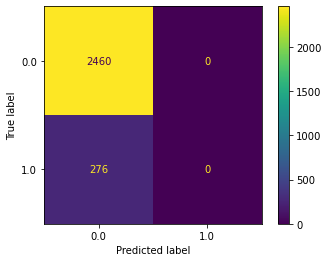

In [42]:
plot_confusion_matrix(arvorecrimes2, X_test, y_test, values_format = '.0f')

Podemos observar que tivemos: 
- 2460 crimes de classificação "0" foram previstos como "0" corretamente.
- Não tivemos casos de classificação "1" previstos corretamente na classificação "1".
- Tivemos 276 ocorrências classificadas como "1" e foram previstos como "0", sendo os falsos negativos.
- Não tivemos casos de classificação "0" previstos como classificação "1", que seriam os falsos positivos.

- __Nome da técnica:__ KNN
<br>__Referências complementares__: https://scikit-learn.org/stable/user_guide.html

Primeiro, vamos normalizar os dados de "X2". Este procedimento é indicado para utilizar o classificador KNN.

In [56]:
X = preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))

Vamos aplicar o classficador para k entre 0 e 9 e verificar o score para cada valor de k. Dessa maneira, poderemos optar pelo k com melhor desempenho.

In [66]:
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Treinamento do modelo e previsão  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

Podemos então plotar o gráfico de como o score se comporta quando variamos o k.

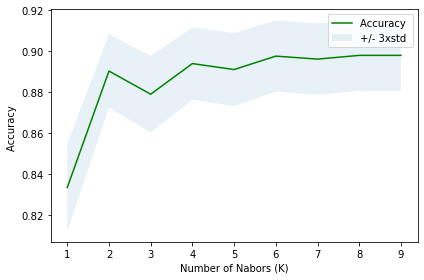

In [67]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

É possível observar que para k igual a 9, temos o melhor valor de score. Este será o k que utilizaremos no nosso modelo.

In [68]:
k = 9
#Treinamento do modelo e previsão  
neigh9 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat9 = neigh9.predict(X_test)
print("KNN's Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("KNN's Test set Accuracy: ", metrics.accuracy_score(y_test, yhat9))
print("KNN's train set Precision: ", metrics.precision_score(y_train, neigh.predict(X_train)))
print("KNN's test set Precision: ", metrics.precision_score(y_test,yhat9))

KNN's Train set Accuracy:  0.9149436090225563
KNN's Test set Accuracy:  0.8980263157894737
KNN's train set Precision:  0.45454545454545453
KNN's test set Precision:  0.2857142857142857


Os valores de acurácia e precisão estão bons. Os valores de precisão também estão interessantes. Vamos observar a matriz de confusão.

In [69]:
confusion_matrix(y_test,yhat9)
#plot_confusion_matrix(yhat9, X_test, y_test, values_format = '.0f')

array([[2455,    5],
       [ 274,    2]], dtype=int64)

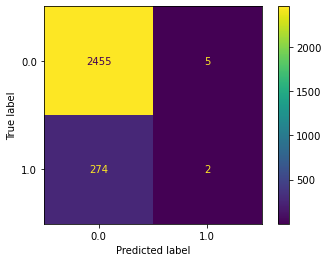

In [70]:
plot_confusion_matrix(neigh9, X_test, y_test, values_format = '.0f')

Podemos observar que tivemos: 
- Tivemos 2455 crimes de classificação "0" foram previstos como "0" corretamente.
- Tivemos 2 casos de classificação "1" previstos corretamente na classificação "1".
- Tivemos 274 ocorrências classificadas como "1" e foram previstos como "0", sendo os falsos negativos.
- Tivemos 5 casos de classificação "0" previstos como classificação "1", que seriam os falsos positivos.

### Análises e conclusões

Com as árvores feitas é possível observar o efeito de algumas características no modelo. Se removermos a coluna CODIGO_CRIME e TEVE_TIRO da análise o modelo piora bastate, o que faz sentido.
<br>
<br>Na verdade, se pensarmos na utilização prática, as colunas CODIGO_CRIME e TEVE_TIRO não devem ser incluidas, pois essas informações são obtidas depois da ocorrência. Se formos pensar em como prever crimes e verificar se há relação com a área que eles ocorrem, dia ou horário, o certo é usar a análise apenas com essas colunas (AREA_REPORTADA, ANO, MES, DIA_DA_SEMANA, DIA_MES, HORA).
<br>
<br>Quando refazemos a árvore, vemos que os resultados pioram bastante, mas são mais reais. Nesse caso, o classificador não foi capaz de prever nenhum crime grave.
<br>
<br>Para efeito de comparação foi utilizado outro modelo de classificação para verificar se os resultados eram melhores para a última situação. Observando os dados de acurácia, precisão e as matrizes de confusão, vemos que para esse caso o classificador KNN foi mais bem sucedido, sendo capaz de prever alguns crimes graves com exatidão.
